# MNIST

MNIST这个数据集一直被利用，作为各个框架的入门教程。在本教程中，我们将展示如何训练实际的模型。我们使用MNIST数据集和LeNet模型，略有改动，即用ReLU代替sigmoid激活函数。

我们将使用model helper，这有助于我们处理模型初始化。

首先，我们导入必备的库。

## 导入库

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import os
import shutil
import operator
import caffe2.python.predictor.predictor_exporter as pe

from caffe2.python import (
    brew,
    core,
    model_helper,
    net_drawer,
    optimizer,
    visualize,
    workspace,
)

# If you would like to see some really detailed initializations,
# you can change --caffe2_log_level=0 to --caffe2_log_level=-1
core.GlobalInit(['caffe2', '--caffe2_log_level=0'])
print("Necessities imported!")

# If True, use the LeNet CNN model
# If False, a multilayer perceptron model is used
USE_LENET_MODEL = True

Couldn't import dot_parser, loading of dot files will not be possible.
Necessities imported!


## 数据整理

我们将在训练期间跟踪统计数据，并将这些数据存储在本地文件夹中。我们需要为数据设置一个数据文件夹，并为统计数据建立一个根文件夹。

In [2]:
# This section preps your image and test set in a lmdb database
def DownloadResource(url, path):
    '''Downloads resources from s3 by url and unzips them to the provided path'''
    import requests, zipfile, StringIO
    print("Downloading... {} to {}".format(url, path))
    r = requests.get(url, stream=True)
    z = zipfile.ZipFile(StringIO.StringIO(r.content))
    z.extractall(path)
    print("Completed download and extraction.")
    
# Setup the paths for the necessary directories 
current_folder = os.path.join(os.path.expanduser('~'), 'caffe2_notebooks')
data_folder = os.path.join(current_folder, 'tutorial_data', 'mnist')
root_folder = os.path.join(current_folder, 'tutorial_files', 'tutorial_mnist')
db_missing = False

# Check if the data folder already exists
if not os.path.exists(data_folder):
    os.makedirs(data_folder)   
    print("Your data folder was not found!! This was generated: {}".format(data_folder))

# Check if the training lmdb exists in the data folder
if os.path.exists(os.path.join(data_folder,"mnist-train-nchw-lmdb")):
    print("lmdb train db found!")
else:
    db_missing = True
    
# Check if the testing lmdb exists in the data folder   
if os.path.exists(os.path.join(data_folder,"mnist-test-nchw-lmdb")):
    print("lmdb test db found!")
else:
    db_missing = True

# Attempt the download of the db if either was missing
if db_missing:
    print("one or both of the MNIST lmbd dbs not found!!")
    db_url = "http://download.caffe2.ai/databases/mnist-lmdb.zip"
    try:
        DownloadResource(db_url, data_folder)
    except Exception as ex:
        print("Failed to download dataset. Please download it manually from {}".format(db_url))
        print("Unzip it and place the two database folders here: {}".format(data_folder))
        raise ex

# Clean up statistics from any old runs
if os.path.exists(root_folder):
    print("Looks like you ran this before, so we need to cleanup those old files...")
    shutil.rmtree(root_folder)
    
os.makedirs(root_folder)
workspace.ResetWorkspace(root_folder)

print("training data folder:" + data_folder)
print("workspace root folder:" + root_folder)

lmdb train db found!
lmdb test db found!
Looks like you ran this before, so we need to cleanup those old files...
training data folder:/home/tianliang/caffe2_notebooks/tutorial_data/mnist
workspace root folder:/home/tianliang/caffe2_notebooks/tutorial_files/tutorial_mnist


我们将使用`ModelHelper`类来表示我们的主模型，并使用`brew`和`Operators`来构建我们的模型。`brew`模块具有一组包装函数，可以自动将参数初始化和实际计算分离为两个网络。在`ModelHelper`对象底层，有两个底层网络`param_init_net`和`net`，分别记录初始化网络和主网络。

为了模块化，我们将模型分为多个不同的部分：
1. 数据输入部分（AddInput 函数）
2. 主计算部分（AddLeNetModel 函数）
3. 训练部分 - 添加梯度运算符，更新等（AddTrainingOperators 函数）
4. 簿记部分，我们只打印统计数据以供检查（AddBookkeepingOperators 函数）

`AddInput`将从DB中加载数据。我们将MNIST数据存储为像素值，因此在批处理之后，这将为我们提供具有形状（batch_size, num_channels, width, height）的数据。类型为`uint8`形状为 `[batch_size, 1, 28, 28]`的数据和类型为`int`形状为`[batch_size]`的标签。

由于我们要做浮点计算，因此我们将把数据类型转换为浮点数据类型。为了获得更好的数值稳定性，我么将它们缩放到[0, 1]，而不是在[0, 255]范围内表示数据。请注意，我们正在为此运算符进行就地计算：我们不需要预先缩放数据。现在，在计算反向回传时，我们不需要为它计算梯度。`StopGradient`的确如此：在前向中它什么都不做，而在反向传播中所做的只是告诉梯度发生器“梯度不需要经过我”。

### 给模型添加输入

In [3]:
def AddInput(model, batch_size, db, db_type):
    ### load the data from db - Method 1 using brew
    #data_uint8, label = brew.db_input(
    #    model,
    #    blobs_out=["data_uint8", "label"],
    #    batch_size=batch_size,
    #    db=db,
    #    db_type=db_type,
    #)
    ### load the data from db - Method 2 using TensorProtosDB
    data_uint8, label = model.TensorProtosDBInput(
        [], ["data_uint8", "label"], batch_size=batch_size,
        db=db, db_type=db_type)
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

下面我们将看到网络将出现的预测转化为概率。输出结果将符合0到1之间，因此越接近1，说明数字越可能与预测相匹配。这个转化是通过softmax函数实现的，我们可以在下面代码中看到。下面的`AddLeNetMode`函数将输出softmax。这个函数不光有softmax，它还是具有卷基层的计算模型。

在[图像处理中对内核的解释](https://en.wikipedia.org/wiki/Kernel_%28image_processing%29)可能对于为什么在下面的卷积图层中使用`kernel=5`提供更多有用的信息。`dim_in`是输入通道的数量，`dim_out`是输出通道的数量。

## 设定多层感知机（MLP）模型

In [4]:
# Function to construct a MLP neural network
# The input 'model' is a model helper and 'data' is the input data blob's name
def AddMLPModel(model, data):
    size = 28 * 28 * 1
    sizes = [size, size * 2, size * 2, 10]
    layer = data
    for i in range(len(sizes) - 1):
        layer = brew.fc(model, layer, 'dense_{}'.format(i), dim_in=sizes[i], dim_out=sizes[i + 1])
        layer = brew.relu(model, layer, 'relu_{}'.format(i))
    softmax = brew.softmax(model, layer, 'softmax')
    return softmax

## 设定LeNet模型

In [5]:
def AddLeNetModel(model, data):
    '''
    This part is the standard LeNet model: from data to the softmax prediction.
    
    For each convolutional layer we specify dim_in - number of input channels
    and dim_out - number or output channels. Also each Conv and MaxPool layer changes the
    image size. For example, kernel of size 5 reduces each side of an image by 4.

    While when we have kernel and stride sizes equal 2 in a MaxPool layer, it divides
    each side in half.
    '''
    # Image size: 28 x 28 -> 24 x 24
    conv1 = brew.conv(model, data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Image size: 24 x 24 -> 12 x 12
    pool1 = brew.max_pool(model, conv1, 'pool1', kernel=2, stride=2)
    # Image size: 12 x 12 -> 8 x 8
    conv2 = brew.conv(model, pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Image size: 8 x 8 -> 4 x 4
    pool2 = brew.max_pool(model, conv2, 'pool2', kernel=2, stride=2)
    # 50 * 4 * 4 stands for dim_out from previous layer multiplied by the image size
    # Here, the data is flattened from a tensor of dimension 50x4x4 to a vector of length 50*4*4
    fc3 = brew.fc(model, pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    relu3 = brew.relu(model, fc3, 'relu3')
    # Last FC Layer
    pred = brew.fc(model, relu3, 'pred', dim_in=500, dim_out=10)
    # Softmax Layer
    softmax = brew.softmax(model, pred, 'softmax')
    
    return softmax

### 控制使用多层感知机模型，还是使用LeNet模型

In [6]:
def AddModel(model, data):
    if USE_LENET_MODEL:
        return AddLeNetModel(model, data)
    else:
        return AddMLPModel(model, data)

### 给模型添加输出精度的层

下面的AddAccuracy函数为模型添加了一个精度运算符。我们将在下一个函数中使用它来跟踪模型的准确性。

In [7]:
def AddAccuracy(model, softmax, label):
    """Adds an accuracy op to the model"""
    accuracy = brew.accuracy(model, [softmax, label], "accuracy")
    return accuracy

接下来的函数`AddTrainingOperators`，将训练operators添加到模型中。

在第一步中，我们应用一个operator `LabelCrossEntropy`，计算输出和标签集之间的交叉熵。在计算模型损失之前，该operator几乎总是在获取softmax之后使用。它将采用`[softmax, label]`矩阵和“Cross Entropy”的标签`xent`。

	xent = model.LabelCrossEntropy([softmax, label], 'xent')

`AveragedLoss` 将取代交叉熵并返回交叉熵中发现的损失的平均值。

    loss = model.AveragedLoss(xent, "loss")

为了簿记目的，我们还将通过调用`AddAccuracy`函数来计算模型的准确性，如下所示：

    AddAccuracy(model, softmax, label)

下一行是训练模型的关键部分：我们将所有梯度运算符添加到模型中。这些梯度是我们在上面计算的损失梯度。

    model.AddGradientOperators([loss])
 
接下来的几行支持非常简单的随机梯度下降。Caffe2的工作人员正在努力包装这些SGD操作，他们会在准备就绪时更新此操作。现在，你可以看到我们如何显示具有基本SGD算法的operators。

`Iter` operator 是我们在训练过程中运行的迭代次数的计数器。我们使用`brew.iter` 辅助函数将其添加到模型中。

    ITER = brew.iter(model, "iter")

我们做了一个简单的学习率方法，其中 `lr = base_lr * (t ^ gamma)`。注意，我们正在做最小化，所以`base_lr`是负数，我们要进入DOWNHILL方向。

    LR = model.LearningRate(
        ITER, "LR", base_lr=-0.1, policy="step", stepsize=1, gamma=0.999 )
        
`ONE`是用于梯度更新的常量值。我们只需要创建一次，所以它明确第放置在`param_init_net`中。

    ONE = model.param_init_net.ConstantFill([], "ONE", shape=[1], value=1.0)

现在， 对于每个参数，我们都会进行梯度更新。我们如何获得每个参数的梯度 - `ModelHelper` 会跟踪这些变量。更新是一个简单的加权和： `param = param + param_grad * LR`

    for param in model.params:
        param_grad = model.param_to_grad[param]
        model.WeightedSum([param, ONE, param_grad, LR], param)        
        
我们需要定期检查模型的参数。这是通过`Checkpoint` operator 完成的。它还需要一个参数“every”，以便我们不会太频繁地使用检查点。这样，我们每20次迭代就让我们checkpoint。

    model.Checkpoint([ITER] + model.params, [],
                   db="mnist_lenet_checkpoint_%05d.lmdb",
                   db_type="lmdb", every=20)


In [8]:
def AddTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    # Compute cross entropy between softmax scores and labels
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # Compute the expected loss
    loss = model.AveragedLoss(xent, "loss")
    # Track the accuracy of the model
    AddAccuracy(model, softmax, label)
    # Use the average loss we just computed to add gradient operators to the model
    model.AddGradientOperators([loss])
    # Specify the optimization algorithm
    optimizer.build_sgd(
        model,
        base_learning_rate=0.1,
        policy="step",
        stepsize=1,
        gamma=0.999,
    )

以下函数`AddBookkeepingOpeators`添加了一些bookkeeping operators，我们稍后可以检查它们。这些operators不会影响训练过程：它们只收集统计信息并将其打印到文件或日志中。

In [9]:
def AddBookkeepingOperators(model):
    """This adds a few bookkeeping operators that we can inspect later.
    
    These operators do not affect the training procedure: they only collect
    statistics and prints them to file or to logs.
    """    
    # Print basically prints out the content of the blob. to_file=1 routes the
    # printed output to a file. The file is going to be stored under
    #     root_folder/[blob name]
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)
    # Summarizes the parameters. Different from Print, Summarize gives some
    # statistics of the parameter, such as mean, std, min and max.
    for param in model.params:
        model.Summarize(param, [], to_file=1)
        model.Summarize(model.param_to_grad[param], [], to_file=1)
    # Now, if we really want to be verbose, we can summarize EVERY blob
    # that the model produces; it is probably not a good idea, because that
    # is going to take time - summarization do not come for free. For this
    # demo, we will only show how to summarize the parameters and their
    # gradients.

现在，让我们创建用于训练和测试的模型。我们之前创建的函数将被执行。请记住我们正在做的四个步骤：
1. 数据输入
2. 主要的计算
3. 训练
4. 簿记

在我们送入数据之前，需要定义我们的训练模型。我们基本上需要上面定义的每一个组件。在这个例子中，我们在mnist_train数据集上使用`HCHW`存储顺序。


In [10]:
#### Train Model
# Specify the data will be input in NCHW order
#  (i.e. [batch_size, num_channels, height, width])
arg_scope = {"order": "NCHW"}
# Create the model helper for the train model
# 为训练模型创建一个model helper
train_model = model_helper.ModelHelper(name="mnist_train", arg_scope=arg_scope)
# Specify the input is from the train lmdb
# 给模型指定输入
data, label = AddInput(
    train_model, batch_size=64,
    db=os.path.join(data_folder, 'mnist-train-nchw-lmdb'),
    db_type='lmdb')
# Add the model definition (fc layers, conv layers, softmax, etc.)
# 给当前的model helper添加模型的定义（比如，全连接层，卷基层和softmax层等...）
softmax = AddModel(train_model, data)
# Add training operators, specify loss function and optimization algorithm
# 给 train_model 添加训练的一些操作，指定损失函数和优化方式
AddTrainingOperators(train_model, softmax, label)
# Add bookkeeping operators to save stats from training
AddBookkeepingOperators(train_model)

#### Testing model. 
# We will set the batch size to 100, so that the testing
#   pass is 100 iterations (10,000 images in total).
#   For the testing model, we need the data input part, the main AddModel
#   part, and an accuracy part. Note that init_params is set False because
#   we will be using the parameters obtained from the train model which will
#   already be in the workspace.
# 这部分用来测试模型
# 同样用model_helper构造一个模型，这个模型的名字上 mnist_test
test_model = model_helper.ModelHelper(
    name="mnist_test", arg_scope=arg_scope, init_params=False)
# 给 mnist_test 添加输入数据接口
data, label = AddInput(
    test_model, batch_size=100,
    db=os.path.join(data_folder, 'mnist-test-nchw-lmdb'),
    db_type='lmdb')
# 给 test_model 添加模型定义
softmax = AddModel(test_model, data)
# 添加精度层
AddAccuracy(test_model, softmax, label)

#### Deployment model. 
# We simply need the main AddModel part.
deploy_model = model_helper.ModelHelper(
    name="mnist_deploy", arg_scope=arg_scope, init_params=False)
AddModel(deploy_model, "data")

BlobReference("softmax")

## 模型可视化
现在，让我们看看使用caffe2所具有的简单图形可视化工具，看看training和deploy模型长什么样子。如果一下命令失败，请安装`graphviz`。安装方式参考下边的命令行：
		
	sudo yum install graphviz

 

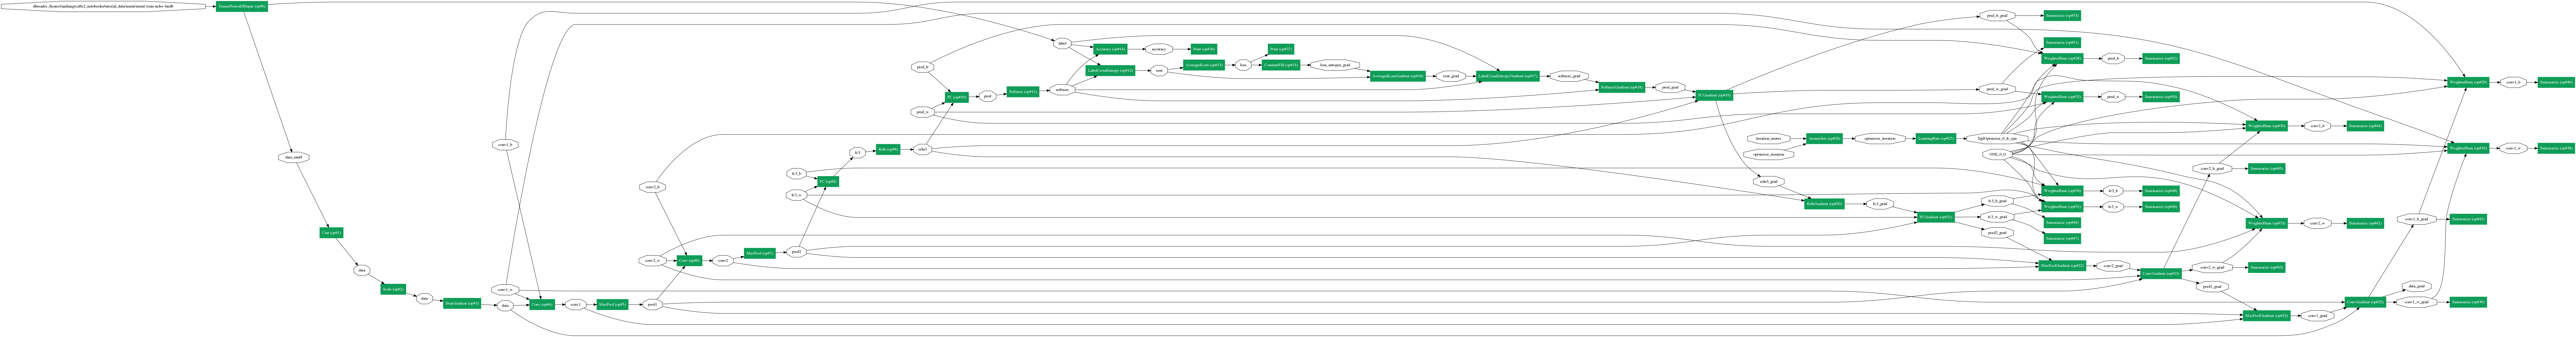

In [11]:
from IPython import display
graph = net_drawer.GetPydotGraph(train_model.net.Proto().op, "mnist", rankdir="LR")
display.Image(graph.create_png(), width=800)

现在，上图显示了训练阶段的一切操作：白色节点是blobs，绿色矩形节点是正在运行的operator。你可以看到这些像轨道一样的平行线路：这些线路是从正向传播山城的blobs到反向operators的依赖关系。

让我们以更简单的方式显示图形，只显示必要的依赖关系并仅显示operators。如果你仔细观察，可以看到图的左半部分是正向传播，图的右半部分是反向传播，右边是一组参数更新和汇总operators。

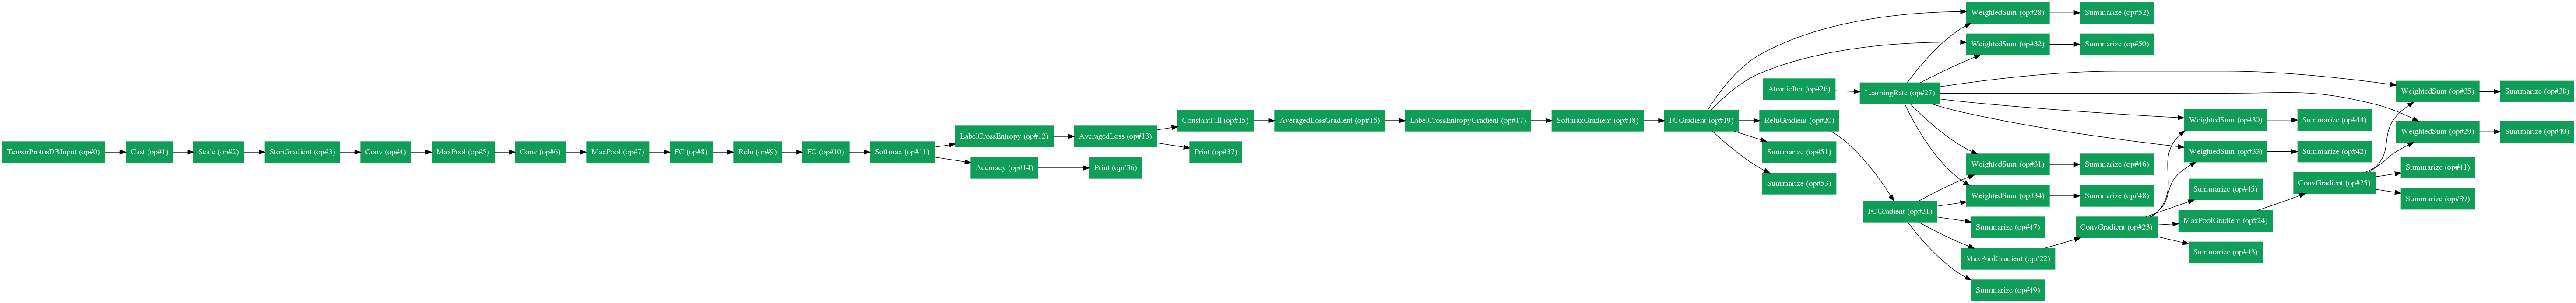

In [12]:
graph = net_drawer.GetPydotGraphMinimal(
    train_model.net.Proto().op, "mnist", rankdir="LR", minimal_dependency=True)
display.Image(graph.create_png(), width=800)

现在，当我们运行网络时，一种方法是直接从Python运行它。当我们运行网络时，我们可以定期从网络中提取blobs，让我们先来说明我们是如何做到这一点。

在此之前，我们再次重申一下，`ModelHelper`类尚未执行任何操作。它所做的只是声明网络，这基本上是创建协议缓冲区。例如，我们将显示训练模型参数初始化网络的一部分序列化协议缓冲区。

In [13]:
print("*******train_model.net.Proto()*******\n")
print(str(train_model.net.Proto())[:400] + '\n...')
print("\n*******train_model.param_init_net.Proto()*******\n")
print(str(train_model.param_init_net.Proto())[:400] + '\n...')

*******train_model.net.Proto()*******

name: "mnist_train"
op {
  input: "dbreader_/home/tianliang/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb"
  output: "data_uint8"
  output: "label"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "batch_size"
    i: 64
  }
}
op {
  input: "data_uint8"
  output: "data"
  name: ""
  type: "Cast"
  arg {
    name: "to"
    i: 1
  }
}
op {
  input: "data"
  output: "data"
  nam
...

*******train_model.param_init_net.Proto()*******

name: "mnist_train_init"
op {
  output: "dbreader_/home/tianliang/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "lmdb"
  }
  arg {
    name: "db"
    s: "/home/tianliang/caffe2_notebooks/tutorial_data/mnist/mnist-train-nchw-lmdb"
  }
}
op {
  output: "conv1_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
  
...


## 运行模型并训练
我们首先必须用以下方式初始化网络：

	workspace.RunNetOnce(train_model.param_init_net)

由于我们要多次运行主网络，我们首选创建一个网络，将从protobuf生成的实际网络放入工作区。

	workspace.CreateNet(train_model.net)

我们将把我们运行网络迭代次数设置为200，并创建两个numpy阵列来记录每次迭代的准确性和损失。

	total_iters = 200
	accuracy = np.zeros(total_iters)
	loss = np.zeros(total_iters)

With the network and tracking of accuracy and loss setup we can now loop the 200 interations calling workspace.
运行网络`RunNet`并传递的网络名称`train_model.net.Proto().name`。在每次迭代中，我们用`workspace.FetchBlob('accuracy')`和`workspace.FetchBlob('loss')`来获取计算的精度和损失。

	for i in range(total_iters):
		workspace.RunNet(train_model.net.Proto().name)
		accuracy[i] = workspace.FetchBlob('accuracy')
		loss[i] = workspace.FetchBlob('loss')
最后，我们可以用pyplot绘制结果。

Iter: 0, Loss: 2.38911485672, Accuracy: 0.09375
Iter: 25, Loss: 0.474105477333, Accuracy: 0.90625
Iter: 50, Loss: 0.251696884632, Accuracy: 0.921875
Iter: 75, Loss: 0.275183916092, Accuracy: 0.921875
Iter: 100, Loss: 0.19101074338, Accuracy: 0.953125
Iter: 125, Loss: 0.207992509007, Accuracy: 0.921875
Iter: 150, Loss: 0.107682660222, Accuracy: 0.96875
Iter: 175, Loss: 0.169761791825, Accuracy: 0.953125


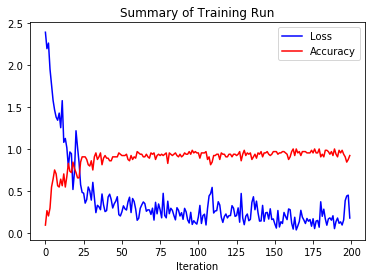

In [14]:
# The parameter initialization network only needs to be run once.
# Now all the parameter blobs are initialized in the workspace.
workspace.RunNetOnce(train_model.param_init_net)

# Creating an actual network as a C++ object in memory.
#   We need this as the object is going to be used a lot
#   so we avoid creating an object every single time it is used.
# overwrite=True allows you to run this cell several times and avoid errors
workspace.CreateNet(train_model.net, overwrite=True)

# Set the iterations number and track the accuracy & loss
total_iters = 200
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)

# MAIN TRAINING LOOP!
# Now, we will manually run the network for 200 iterations. 
for i in range(total_iters):
    workspace.RunNet(train_model.net)
    accuracy[i] = workspace.blobs['accuracy']
    loss[i] = workspace.blobs['loss']
    # Check the accuracy and loss every so often
    if i % 25 == 0:
        print("Iter: {}, Loss: {}, Accuracy: {}".format(i,loss[i],accuracy[i]))

# After the execution is done, let's plot the values.
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.title("Summary of Training Run")
pyplot.xlabel("Iteration")
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

现在我们可以采样一些数据并做出预测。

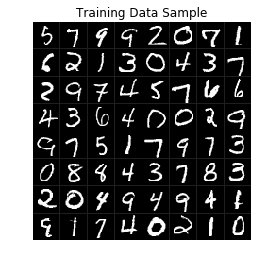

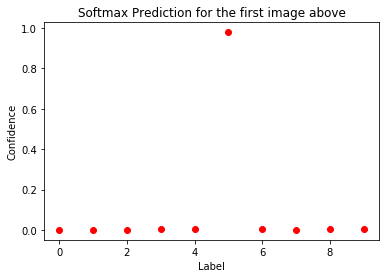

In [15]:
### Let's look at some of the training data
pyplot.figure()
pyplot.title("Training Data Sample")
# Grab the most recent data blob (i.e. batch) from the workspace
data = workspace.FetchBlob('data')
# Use visualize module to show the examples from the last batch that was fed to the model
_ = visualize.NCHW.ShowMultiple(data)

### Let's visualize the softmax result
pyplot.figure()
pyplot.title('Softmax Prediction for the first image above')
pyplot.ylabel('Confidence')
pyplot.xlabel('Label')
# Grab and visualize the softmax blob for the batch we just visualized. Since batch size
#  is 64, the softmax blob contains 64 vectors, one for each image in the batch. To grab
#  the vector for the first image, we can simply index the fetched softmax blob at zero.
softmax = workspace.FetchBlob('softmax')
_ = pyplot.plot(softmax[0], 'ro')

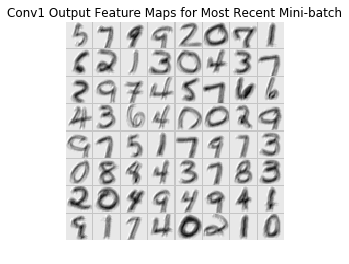

In [16]:
if USE_LENET_MODEL:
    pyplot.figure()
    pyplot.title("Conv1 Output Feature Maps for Most Recent Mini-batch")
    # Grab the output feature maps of conv1. Change this to conv2 in order to look into the second one.
    #  Remember, early convolutional layers tend to learn human-interpretable features but later conv
    #  layers work with highly-abstract representations. For this reason, it may be harder to understand
    #  features of the later conv layers.
    conv = workspace.FetchBlob('conv1')
    
    # We can look into any channel. Think of it as a feature model learned.
    # In this case we look into the 5th channel. Play with other channels to see other features
    conv = conv[:,[5],:,:]

    _ = visualize.NCHW.ShowMultiple(conv)

我们将运行测试网络，并再次报告测试精度。请注意，虽然test_model将使用从train_model获取的参数，但仍然必须运行`test_model.param_init_net`以初始化输入数据。在此次运行中，我们只需要跟踪精度，而且我们只需要运行100次迭代。

test_accuracy: 0.958300


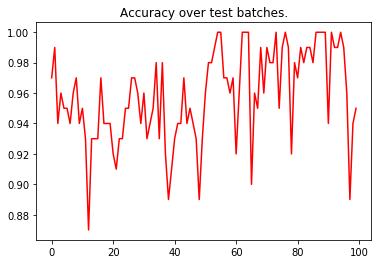

In [17]:
# param_init_net here will only create a data reader
# Other parameters won't be re-created because we selected init_params=False before
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)

# Testing Loop 
test_accuracy = np.zeros(100)
for i in range(100):
    # Run a forward pass of the net on the current batch
    workspace.RunNet(test_model.net)
    # Collect the batch accuracy from the workspace
    test_accuracy[i] = workspace.FetchBlob('accuracy')
    
# After the execution is done, let's plot the accuracy values.
pyplot.plot(test_accuracy, 'r')
pyplot.title('Accuracy over test batches.')
print('test_accuracy: %f' % test_accuracy.mean())

## 模型权重保存
让我们将训练后的权重和偏差保存到文件中。

In [18]:
# construct the model to be exported
# the inputs/outputs of the model are manually specified.
pe_meta = pe.PredictorExportMeta(
    predict_net=deploy_model.net.Proto(),
    parameters=[str(b) for b in deploy_model.params], 
    inputs=["data"],
    outputs=["softmax"],
)

# save the model to a file. Use minidb as the file format
pe.save_to_db("minidb", os.path.join(root_folder, "mnist_model.minidb"), pe_meta)
print("Deploy model saved to: " + root_folder + "/mnist_model.minidb")

Deploy model saved to: /home/tianliang/caffe2_notebooks/tutorial_files/tutorial_mnist/mnist_model.minidb


## 加载保存的模型并预测
现在，我们可以加载模型并运行prediction来验证它是否有效。

The blobs in the workspace after reset: []
The blobs in the workspace after loading the model: [u'!!META_NET_DEF', u'!!PREDICTOR_DBREADER', u'conv1', u'conv1_b', u'conv1_w', u'conv2', u'conv2_b', u'conv2_w', u'data', u'fc3', u'fc3_b', u'fc3_w', u'pool1', u'pool2', u'pred', u'pred_b', u'pred_w', u'relu3', u'softmax']
Shape of softmax:  (100, 10)
Prediction:  8
Confidence:  0.9637974


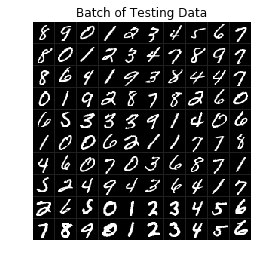

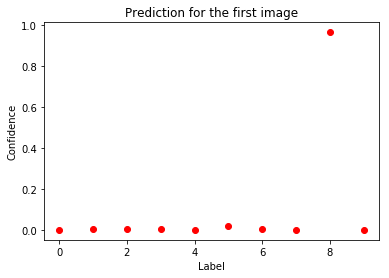

In [19]:
# Grab and display the last data batch used before we scratch the workspace. This purely for our convenience...
blob = workspace.FetchBlob("data")
pyplot.figure()
pyplot.title("Batch of Testing Data")
_ = visualize.NCHW.ShowMultiple(blob)

# reset the workspace, to make sure the model is actually loaded
workspace.ResetWorkspace(root_folder)

# verify that all blobs from training are destroyed. 
print("The blobs in the workspace after reset: {}".format(workspace.Blobs()))

# load the predict net
# 加载预测的网络
predict_net = pe.prepare_prediction_net(os.path.join(root_folder, "mnist_model.minidb"), "minidb")

# verify that blobs are loaded back
print("The blobs in the workspace after loading the model: {}".format(workspace.Blobs()))

# feed the previously saved data to the loaded model
# 
workspace.FeedBlob("data", blob)

# predict
# 预测
workspace.RunNetOnce(predict_net)
softmax = workspace.FetchBlob("softmax")

print("Shape of softmax: ",softmax.shape)

# Quick way to get the top-1 prediction result
# Squeeze out the unnecessary axis. This returns a 1-D array of length 10
# Get the prediction and the confidence by finding the maximum value and index of maximum value in preds array
curr_pred, curr_conf = max(enumerate(softmax[0]), key=operator.itemgetter(1))
print("Prediction: ", curr_pred)
print("Confidence: ", curr_conf)

# the first letter should be predicted correctly
pyplot.figure()
pyplot.title('Prediction for the first image')
pyplot.ylabel('Confidence')
pyplot.xlabel('Label')
_ = pyplot.plot(softmax[0], 'ro')